# Self-Driving Car Engineer Nanodegree
##  Project: Vehicle Detection & Tracking

In [1]:
import numpy as np
import pickle
import cv2
import glob
import time

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

%matplotlib inline

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0614400/45929032 bytes (1.31712128/45929032 bytes (3.7%3325952/45929032 bytes (7.2%5644288/45929032 bytes (12.39011200/45929032 bytes (19.613164544/45929032 bytes (28.7%17276928/45929032 bytes (37.6%21430272/45929032 bytes (46.7%25550848/45929032 bytes (55.6%29638656/45929032 bytes (64.5%33701888/45929032 bytes (73.4%37806080/45929032 bytes (82.3%41852928/45929032 bytes (91.1%45929032/45929032 bytes (100.045929032/45929032 bytes (100.0%)
  Done
File saved as /home/bipe26194/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1.


<h2> Data Visualization

In [12]:
car_images = glob.glob('data/vehicles/**/*.png')
noncar_images = glob.glob('data/non-vehicles/**/*.png')
print("Number of car images:", len(car_images))
print("Number of noncar images:", len(noncar_images))

cars = [] # list to hold car images files
notcars = [] # list to hold non car images file

# populate the car list images
for image in car_images:
    cars.append(image)

# populate the non car images list
for image in noncar_images:
    notcars.append(image)

Number of car images: 8792
Number of noncar images: 8968


In [4]:
def plt_images(image_1, title_1, image_2, title_2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image_1)
    ax1.set_title(title_1, fontsize=30)
    ax2.imshow(image_2)
    ax2.set_title(title_2, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

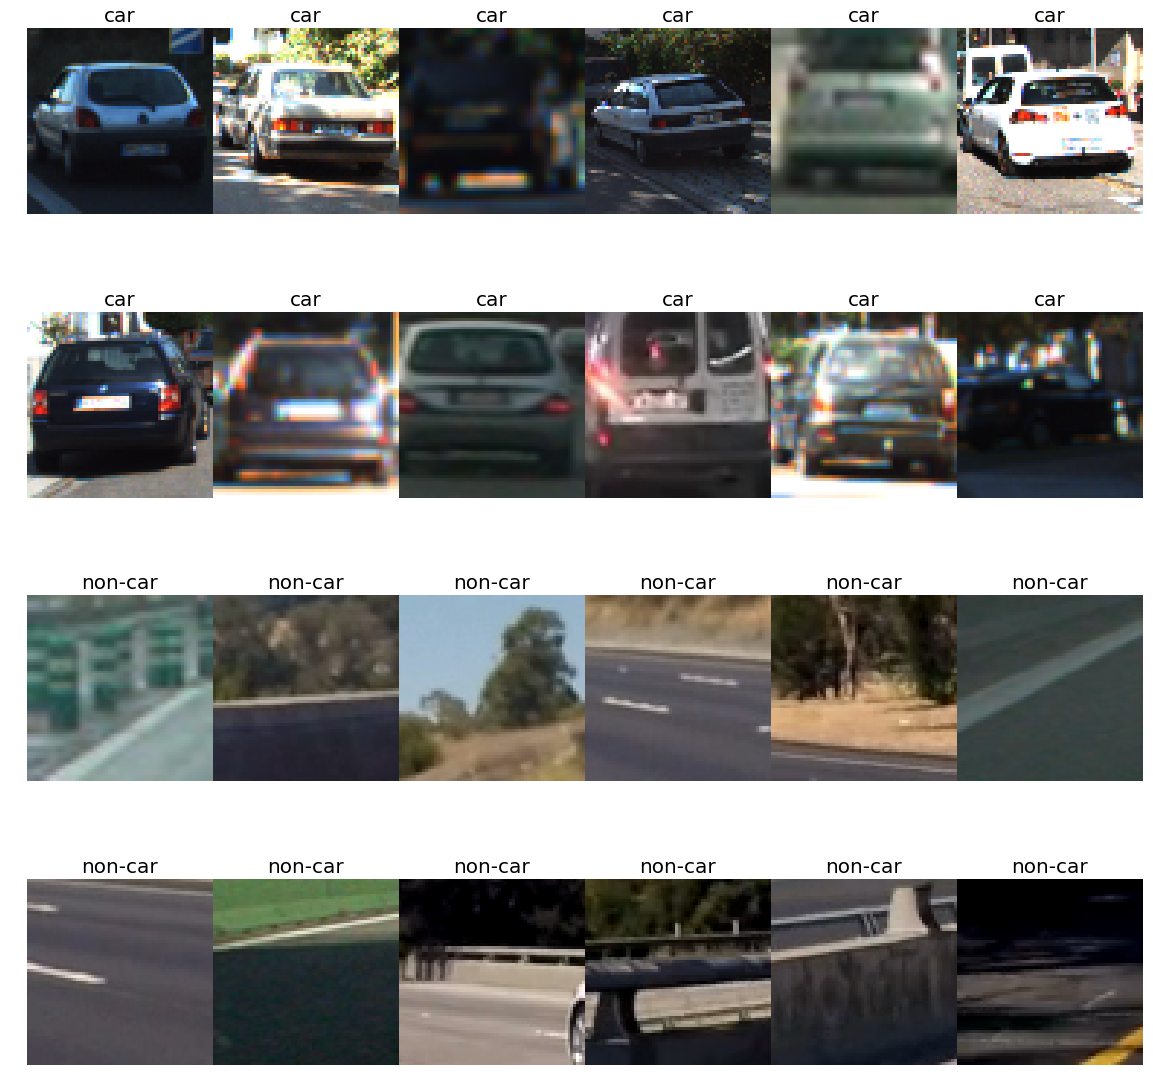

In [8]:
fig, axis = plt.subplots(4,6, figsize=(20, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axis = axis.ravel()

for i in np.arange(12):
    img = cv2.imread(car_images[np.random.randint(0, len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axis[i].axis('off')
    axis[i].set_title('car', fontsize=20)
    axis[i].imshow(img)
    
for i in np.arange(12, 24):
    img = cv2.imread(noncar_images[np.random.randint(0, len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axis[i].axis('off')
    axis[i].set_title('non-car', fontsize=20)
    axis[i].imshow(img)

## Utilities

In [9]:
# function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# function to return image in different color space
def color_spaces(img, color_space='RGB'):
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
    return feature_image
    
# function to extract features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion
        feature_image = color_spaces(image, cspace)
        # apply spatial binning
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # append spatial features
        file_features.append(spatial_features)
        # apply color histogram
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # append color histogram features
        file_features.append(hist_features)
        # apply hog features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features = np.append(hog_features, get_hog_features(feature_image[:,:,channel], 
                                                     orient, pix_per_cell, cell_per_block, 
                                                     vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # append hog features
        file_features.append(hog_features)
        # append file features to final features list
        features.append(np.concatenate(file_features))
    # return feature list vector
    return features

## Feature Extraction & Visualization

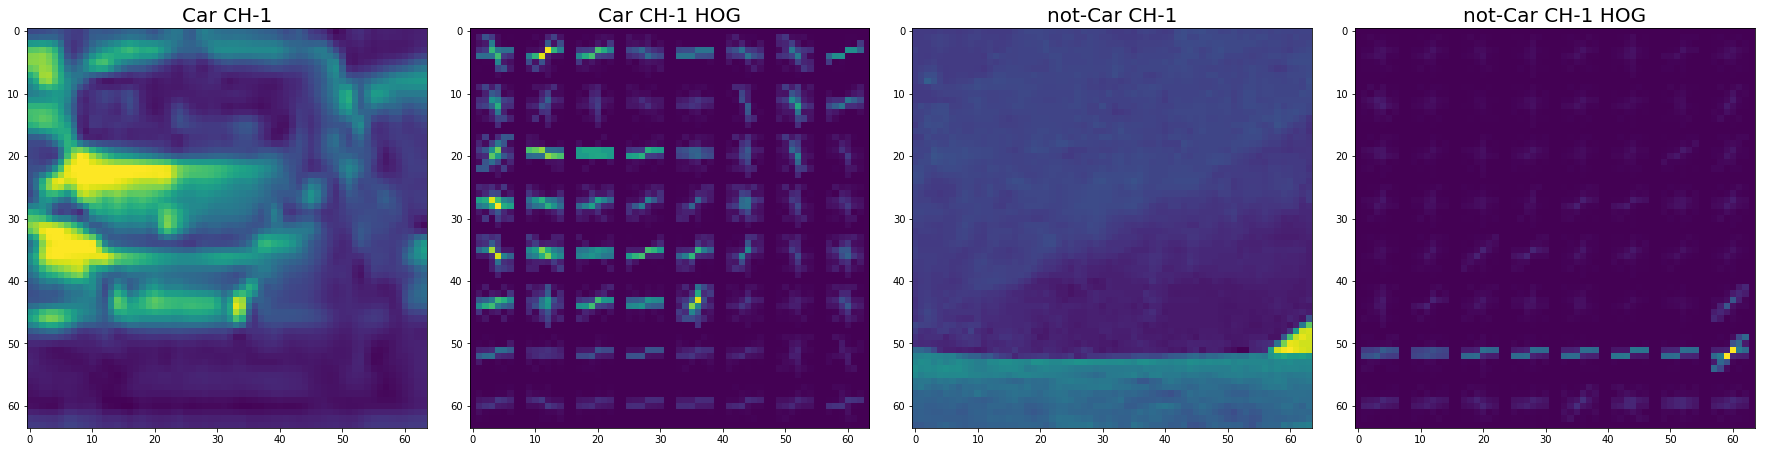

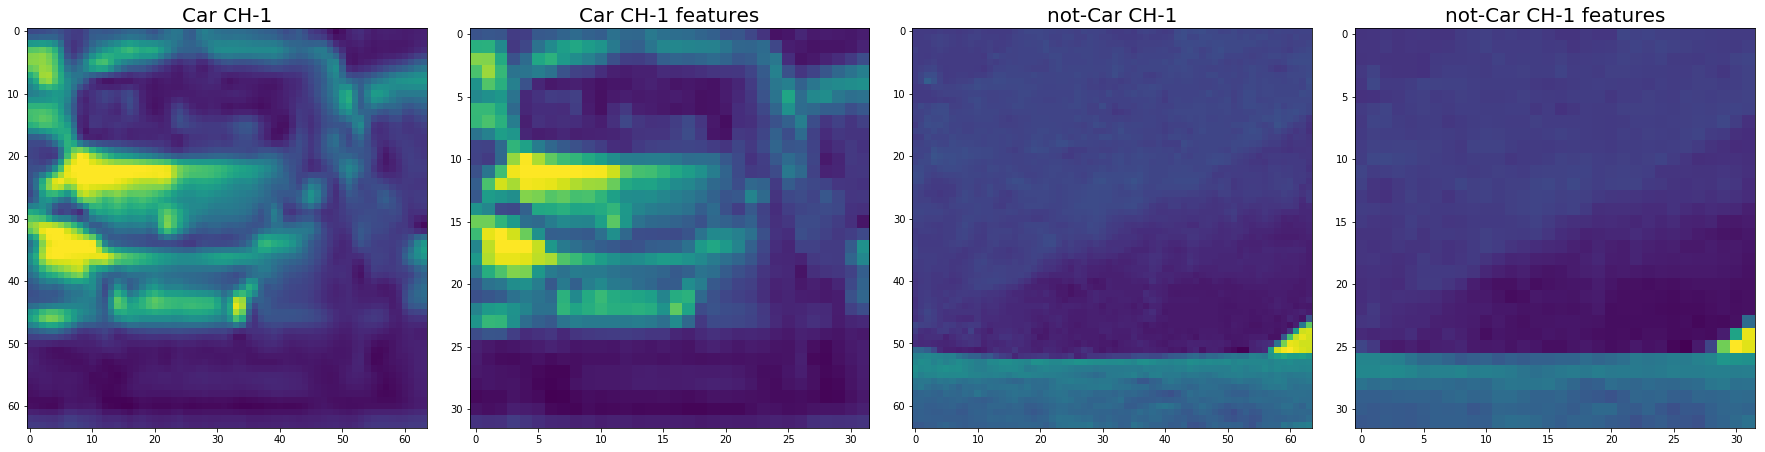

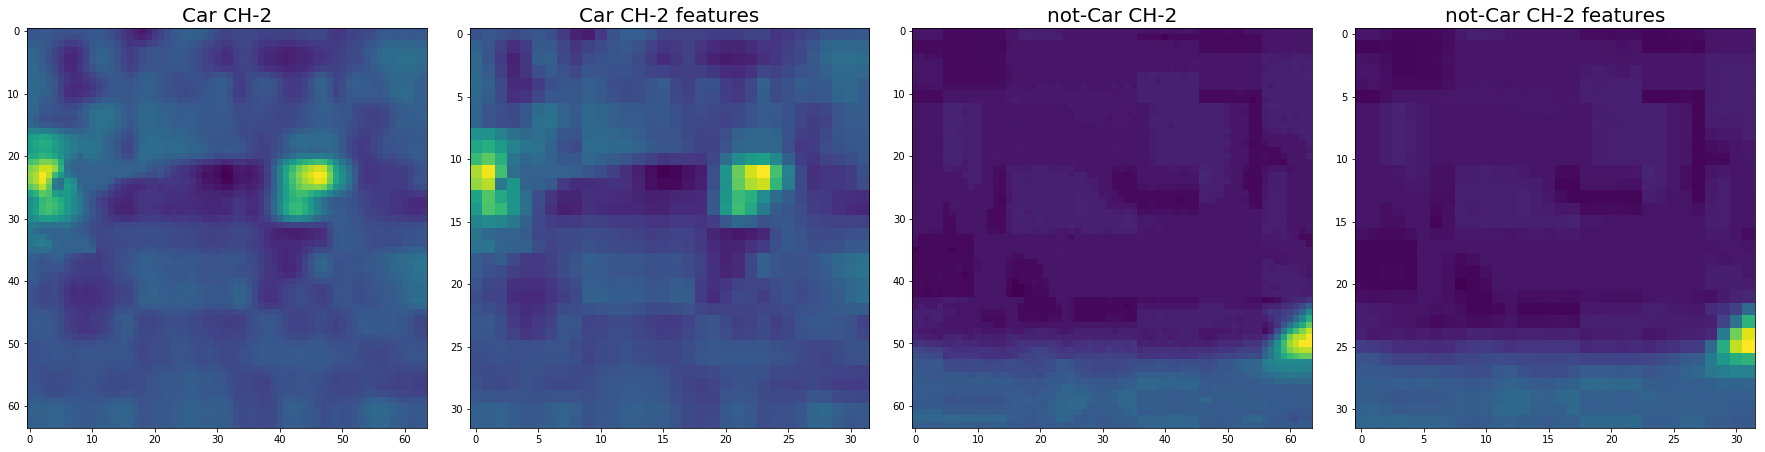

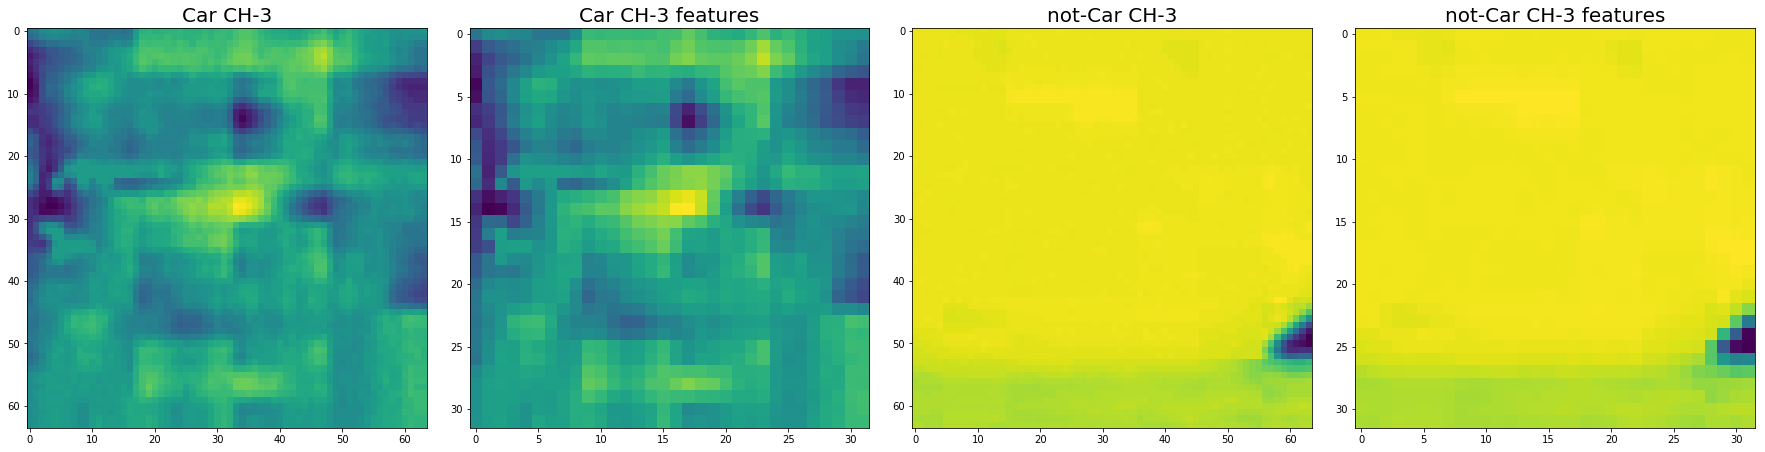

In [13]:
cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

# extract the car features
car_features = extract_features(cars, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
# extract non car fetaures
notcar_features = extract_features(notcars, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel)

## Visulization of the data

# get some random value for car and non car images
car_image = mpimg.imread(cars[100])
notcar_image = mpimg.imread(notcars[100])

# convert the car image into cspace color space and extract chanels from it
color_space_car_image = color_spaces(car_image, cspace)
car_ch1 = color_space_car_image[:,:,0]
car_ch2 = color_space_car_image[:,:,1]
car_ch3 = color_space_car_image[:,:,2]

# convert the non car image into cspace color space and extract chanels from it
color_space_notcar_image = color_spaces(notcar_image, cspace)
notcar_ch1 = color_space_notcar_image[:,:,0]
notcar_ch2 = color_space_notcar_image[:,:,1]
notcar_ch3 = color_space_notcar_image[:,:,2]

# get the hog features and the visualization for channel 1 of car image
car_hog_feature, car_hog_image = get_hog_features(car_ch1, orient, pix_per_cell, cell_per_block, vis=True, 
                                                  feature_vec=True)

# get the hog features and the visualization for channel 1 of non car image
notcar_hog_feature, notcar_hog_image = get_hog_features(notcar_ch1, orient, pix_per_cell, cell_per_block, 
                                                        vis=True, feature_vec=True)

# compute the spatial bin features for all the channels of car and non car image
car_ch1_features = cv2.resize(car_ch1, spatial_size)
car_ch2_features = cv2.resize(car_ch2, spatial_size)
car_ch3_features = cv2.resize(car_ch3, spatial_size)
notcar_ch1_features = cv2.resize(notcar_ch1, spatial_size)
notcar_ch2_features = cv2.resize(notcar_ch2, spatial_size)
notcar_ch3_features = cv2.resize(notcar_ch3, spatial_size)

def show_images(image1, image2, image3, image4,  image1_title="Image 1", image2_title="Image 2", 
                image3_title="Image 3", image4_title="Image 4"):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_title, fontsize=20)
    ax2.imshow(image2)
    ax2.set_title(image2_title, fontsize=20)
    ax3.imshow(image3)
    ax3.set_title(image3_title, fontsize=20)
    ax4.imshow(image4)
    ax4.set_title(image4_title, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

show_images(car_ch1, car_hog_image, notcar_ch1, notcar_hog_image, "Car CH-1", "Car CH-1 HOG", "not-Car CH-1", "not-Car CH-1 HOG")    
show_images(car_ch1, car_ch1_features, notcar_ch1, notcar_ch1_features, "Car CH-1", "Car CH-1 features", "not-Car CH-1", "not-Car CH-1 features")    
show_images(car_ch2, car_ch2_features, notcar_ch2, notcar_ch2_features, "Car CH-2", "Car CH-2 features", "not-Car CH-2", "not-Car CH-2 features")    
show_images(car_ch3, car_ch3_features, notcar_ch3, notcar_ch3_features, "Car CH-3", "Car CH-3 features", "not-Car CH-3", "not-Car CH-3 features")

## SVC Classifier 

In [14]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Feature vector length: 11988
10.42 Seconds to train SVC...
Test Accuracy of SVC =  0.9882
My SVC predicts:  [0. 1. 0. 1. 0. 0. 0. 1. 0. 1.]
For these 10 labels:  [0. 1. 0. 1. 0. 0. 0. 1. 0. 1.]
0.00176 Seconds to predict 10 labels with SVC


## Hog Sub-sampling Sliding Window Search

The `find_cars` function only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. This means that a cells_per_step = 2 would result in a search window overlap of 75%. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows as done later.

In [23]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale):
    
    # array of rectangles where cars were detected
    rectangles = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = color_spaces(img_tosearch, color_space=cspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    return rectangles

## Draw bounding boxes

In [24]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Testing

7 rectangles found in image


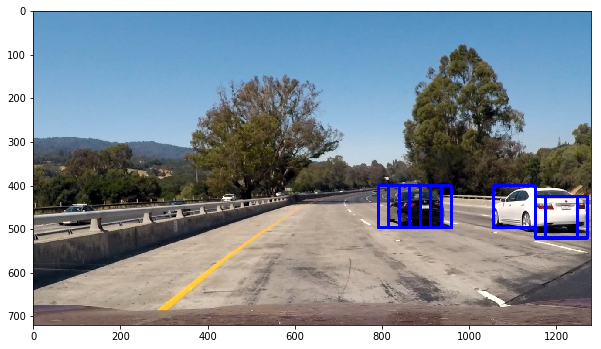

In [26]:
ystart = 400
ystop = 656
scale = 1.5

# read a random test image
test_image = mpimg.imread('./test_images/test1.jpg')
rectangles = find_cars(test_image, ystart, ystop, scale)

print(len(rectangles), 'rectangles found in image')
output_image = draw_boxes(test_image, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(output_image)

## Detecting Potential Search Areas by Experimentation
Depending on the distance of the object from the camera, the size and position of the cars in the image will be different, so I have experimented with varying values of ystart, ystop and scale in `find_cars` function to find the most suitable values.

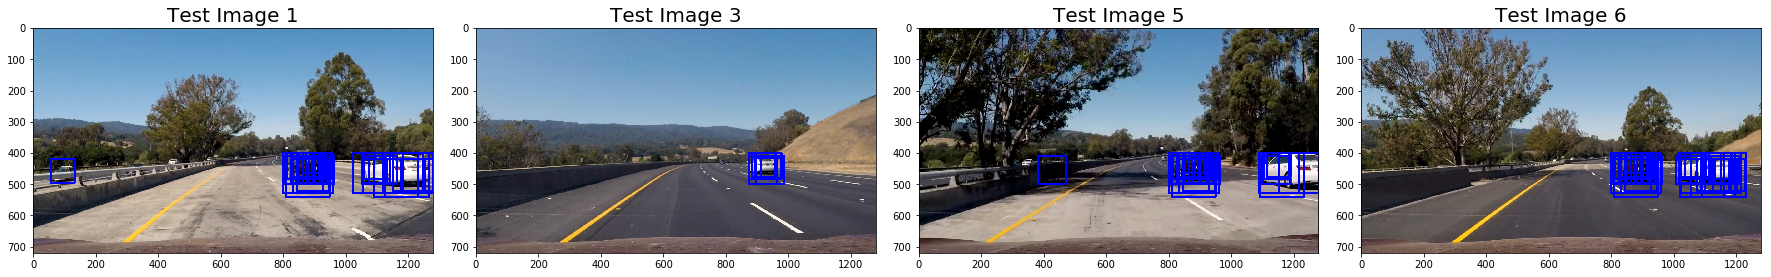

In [29]:
def apply_random_sliding_window(test_image):
    def find_boxes(ystart, ystop, scale):
        box = find_cars(test_image, ystart, ystop, scale)
        return box
    
    specs = [(400, 500, 1.0),
             (400, 500, 1.2),
             (400, 500, 1.3),
             (410, 500, 1.4),
             (420, 556, 1.6),
             (432, 528, 1.7),
             (430, 556, 1.8),
             (440, 556, 1.9),
             (400, 556, 2.0),
             (400, 556, 2.2),
             (500, 650, 3.0),
             (464, 660, 3.5),
             (400, 596, 3.5)]
    bboxes = []
    for spec in specs:
        bboxes.extend(find_boxes(*spec))
        
    return bboxes

# read some random test image
test_image1 = mpimg.imread('./test_images/test1.jpg')
rectangles1 = apply_random_sliding_window(test_image1)

test_image2 = mpimg.imread('./test_images/test3.jpg')
rectangles2 = apply_random_sliding_window(test_image2)

test_image3 = mpimg.imread('./test_images/test5.jpg')
rectangles3 = apply_random_sliding_window(test_image3)

test_image4 = mpimg.imread('./test_images/test6.jpg')
rectangles4 = apply_random_sliding_window(test_image4)
output_image4 = draw_boxes(test_image4, rectangles4)

show_images(output_image1, output_image2, output_image3, output_image4, "Test Image 1", "Test Image 3", 
            "Test Image 5", "Test Image 6")    

## Create Heatmaps
For the above test images, there are overlapping and false positive detections. Thus, I've used heat map technique in order to combine overlapping detections and remove false positives.

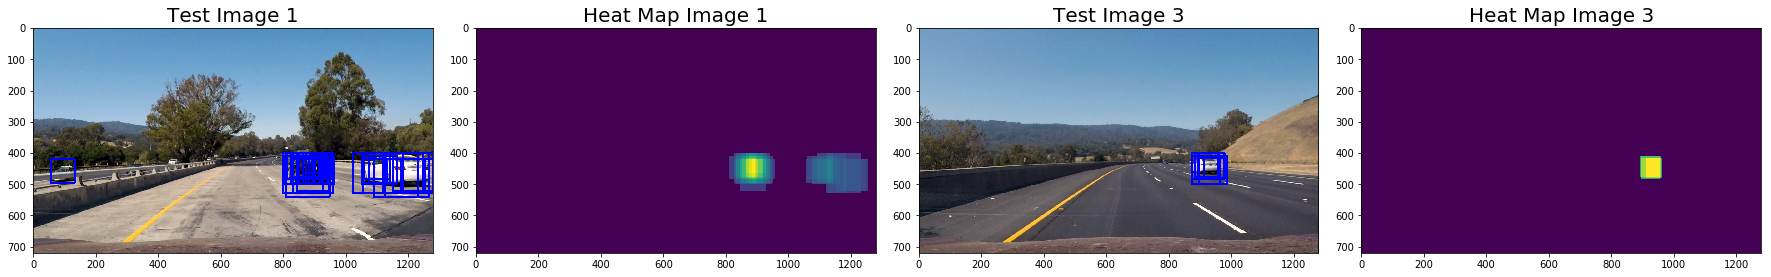

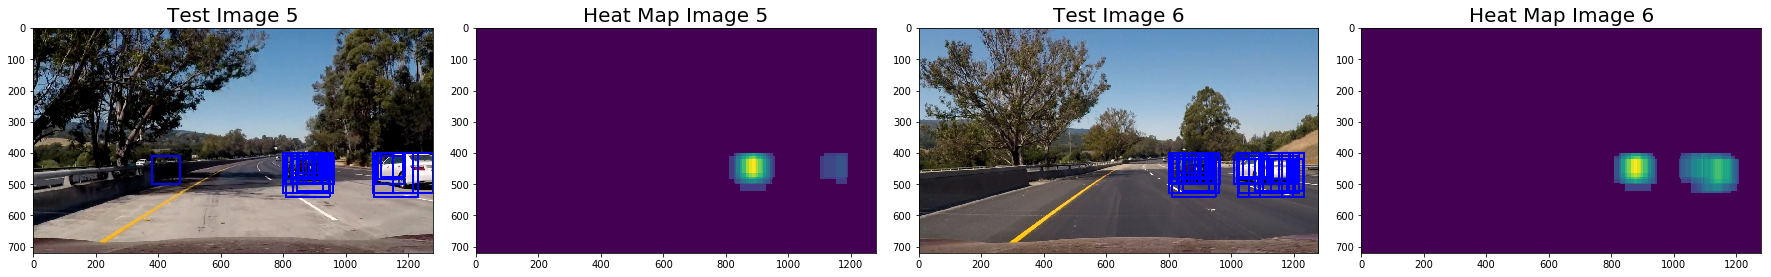

In [31]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def apply_heatmap(output_image, bboxes):
    threshold = 3
    heat = np.zeros_like(output_image[:,:,0]).astype(np.float) 
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    return heatmap

heatmap_image1 = apply_heatmap(output_image1, rectangles1)
heatmap_image2 = apply_heatmap(output_image2, rectangles2)
heatmap_image3 = apply_heatmap(output_image3, rectangles3)
heatmap_image4 = apply_heatmap(output_image4, rectangles4)

show_images(output_image1, heatmap_image1, output_image2, heatmap_image2, "Test Image 1", "Heat Map Image 1", 
            "Test Image 3", "Heat Map Image 3") 
show_images(output_image3, heatmap_image3, output_image4, heatmap_image4, "Test Image 5", "Heat Map Image 5", 
            "Test Image 6", "Heat Map Image 6") 

## Apply Label
After having a thresholded heat map, there are many ways to determine the number of cars in each frame and which pixels belong to which car, but I chose to use the `label` function from scipy.ndimage.measurements. This method can remove multiple detections.

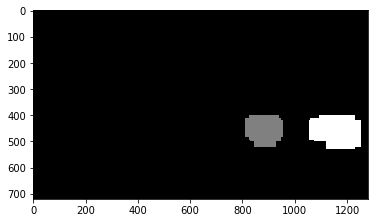

In [32]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def apply_label(image, heatmap):
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    # Draw bounding boxes on a copy of the image
    draw_image = draw_labeled_bboxes(np.copy(image), labels)
    return draw_image

labels = label(heatmap_image1)
plt.imshow(labels[0], cmap='gray')

## Final Output

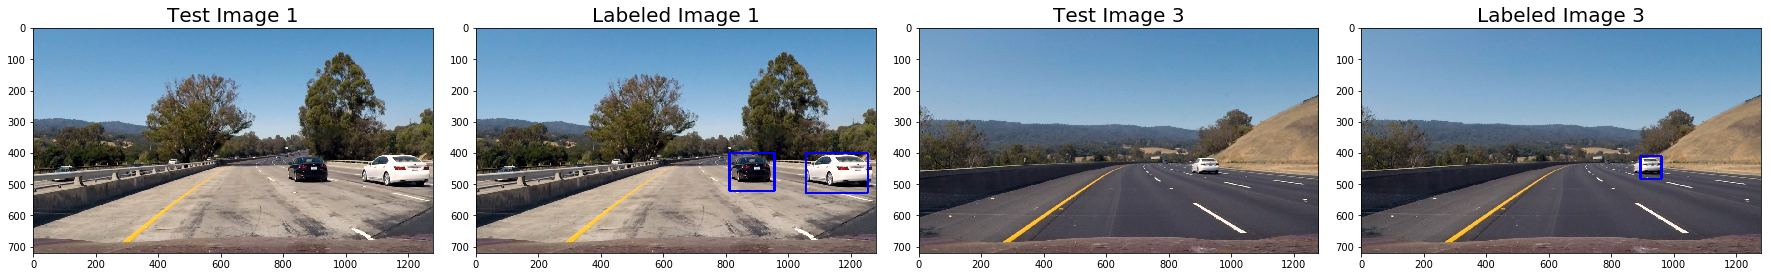

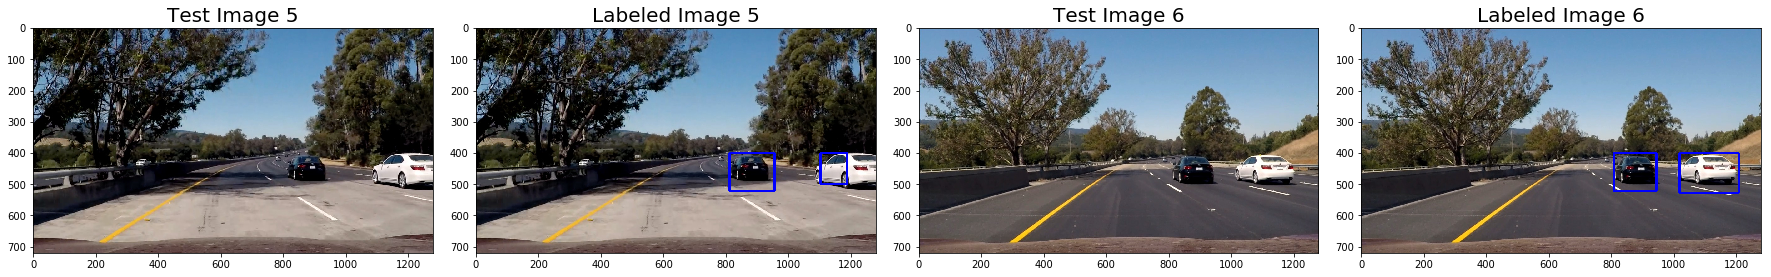

In [35]:
labeled_image1 = apply_label(test_image1, heatmap_image1)
labeled_image2 = apply_label(test_image2, heatmap_image2)
labeled_image3 = apply_label(test_image3, heatmap_image3)
labeled_image4 = apply_label(test_image4, heatmap_image4)

show_images(test_image1, labeled_image1, test_image2, labeled_image2, "Test Image 1", "Labeled Image 1", 
            "Test Image 3", "Labeled Image 3") 
show_images(test_image3, labeled_image3, test_image4, labeled_image4, "Test Image 5", "Labeled Image 5", 
            "Test Image 6", "Labeled Image 6") 

## Video Processing Pipeline

In [38]:
def process_pipeline(image):
    rectangles = apply_random_sliding_window(image)
    output_image = draw_boxes(image, rectangles)
    current_heatmap = apply_heatmap(output_image, rectangles)
    history.append(current_heatmap)
    heatmap = np.zeros_like(current_heatmap).astype(np.float)
    for heat in history:
        heatmap = heatmap + heat
    draw_image = apply_label(image, heatmap)
    return draw_image

In [39]:
history = deque(maxlen = 10)
output = './output_videos/test_video_output.mp4'
clip = VideoFileClip("./test_videos/test_video.mp4")
video_clip = clip.fl_image(process_pipeline)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output_videos/test_video_output.mp4
[MoviePy] Writing video ./output_videos/test_video_output.mp4


 97%|█████████▋| 38/39 [00:46<00:01,  1.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/test_video_output.mp4 

CPU times: user 2min 57s, sys: 7.09 s, total: 3min 4s
Wall time: 47.8 s


In [40]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('test_video_output.mp4'))

In [41]:
history = deque(maxlen = 10)
output = './output_videos/project_video_output.mp4'
clip = VideoFileClip("./test_videos/project_video.mp4")
video_clip = clip.fl_image(process_pipeline).subclip(0, 2)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video_output.mp4
[MoviePy] Writing video ./output_videos/project_video_output.mp4


 98%|█████████▊| 50/51 [01:01<00:01,  1.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_output.mp4 

CPU times: user 3min 51s, sys: 9.14 s, total: 4min 1s
Wall time: 1min 1s


In [42]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('project_video_output.mp4'))